In [137]:
import rebound
import numpy as np
import scipy
%matplotlib inline
import matplotlib;
import matplotlib.pyplot as plt
import scipy.optimize as opt
from scipy.integrate import ode

Homotopy function
$$H(a,\lambda) = \lambda \frac{\partial \chi_{\rm nbody}}{\partial a} + (1-\lambda) \frac{\partial \chi_{\rm simple}}{\partial a}$$
where
$$\chi_{\rm nbody} = \sum \left(v_i-obs_i\right)^2$$
$$\chi_{\rm simple} = \sum \left(10^{-3}\sin\left(\frac{t_i}{\sqrt{a^3}}\right)+10^{-3}\sin\left(\frac{t_i}{\sqrt{a_o^3}}\right)-obs_i\right)^2$$

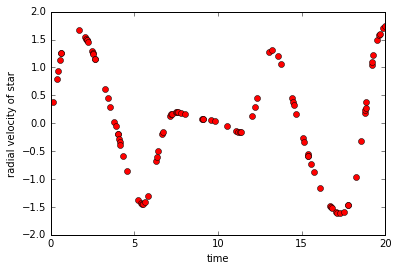

In [3]:
sample_times = np.sort(np.random.rand(100)*20.)
x_true = (1.0,0.2500)
def generatedata(x):
    a, e = x
    sim = rebound.Simulation()
    sim.add(m=1.)
    sim.add(primary=sim.particles[0],m=1e-3, a=a, e=e)
    sim.add(primary=sim.particles[0],m=1e-3, a=1.3)
    sim.move_to_com()
    samples = np.zeros((len(sample_times)))
    for i,t in enumerate(sample_times):
        sim.integrate(t)
        samples[i] = sim.particles[0].vx
    return samples
samples_true = generatedata(x_true)
fig = plt.figure(figsize=(6,4))
ax = plt.subplot(111)
ax.set_xlabel("time"); ax.set_ylabel("radial velocity of star")
im = ax.plot(sample_times, 1000.*samples_true, "ro")

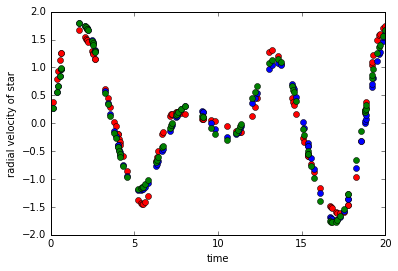

In [23]:
def simple_chi2_a(a):
    return chi2_simple((a,0.))[0]
def simple(x):
    a, e = x
    samples = np.zeros((len(sample_times)))
    for i,t in enumerate(sample_times):
        amp1 = 1e-3*np.sqrt(1./a)
        amp2 = 1e-3*np.sqrt(1./1.3)
        samples[i] = amp1*np.sin(t*pow(a,-3./2.))+amp2*np.sin(t*pow(1.3,-3./2.))
    return samples
def chi2_simple(x):
    a, e = x
    if a<0.1 or a>5 or e<0. or e>0.8:
        return 1000., 0.
    chi2 = 0.
    chi2_da = 0.
    chi2_dda = 0.
    for i,t in enumerate(sample_times):
        amp1 = 1e-3*np.sqrt(1./a)
        amp2 = 1e-3*np.sqrt(1./1.3)
        v = amp1*np.sin(t*pow(a,-3./2.))+amp2*np.sin(t*pow(1.3,-3./2.))
        v_da = -0.5*1e-3*a**(-3./2.)*np.sin(t*pow(a,-3./2.))+1e-3*a**(-3)*np.cos(t*pow(a,-3./2.))*t*(-3./2.)
        v_dda = 3./4.*1e-3*a**(-5./2.)*np.sin(t*pow(a,-3./2.))             -0.5*1e-3*a**(-3./2.)*np.cos(t*pow(a,-3./2.))*t*(-3./2.)*a**(-5./2.)            -1e-3*a**(-3)*np.sin(t*pow(a,-3./2.))*t*(-3./2.)*t*(-3./2.)*a**(-5./2.)            -3.*1e-3*a**(-4)*np.cos(t*pow(a,-3./2.))*t*(-3./2.)
        chi2 += (v-samples_true[i])**2
        chi2_da += 2.*v_da*(v-samples_true[i])
        chi2_dda += 2.*v_dda*(v-samples_true[i])            + 2.*v_da*v_da
        
    chi2_d  = np.array([chi2_da, 0.])
    chi2_dd = np.array([[chi2_dda, 0.],[0.,0.]])
    return chi2, chi2_d, chi2_dd

samples_simple = simple(x_true)
simple_a = float(opt.fmin_powell(simple_chi2_a, 1.03, disp=False,ftol=1e-15,xtol=1e-15))
samples_simple_bestfit = simple((simple_a,0.))
fig = plt.figure(figsize=(6,4))
ax = plt.subplot(111)
ax.set_xlabel("time"); ax.set_ylabel("radial velocity of star")
im = ax.plot(sample_times, 1000.*samples_true, "ro")
im = ax.plot(sample_times, 1000.*samples_simple, "bo")
im = ax.plot(sample_times, 1000.*samples_simple_bestfit, "go")

In [74]:
def chi2_nbody(x):
    a, e = x
    sim = rebound.Simulation()
    sim.add(m=1.)
    sim.add(primary=sim.particles[0],m=1e-3, a=a, e=e)
    sim.add(primary=sim.particles[0],m=1e-3, a=1.3)
    var_da = sim.add_variation()
    var_dda = sim.add_variation(order=2, first_order=var_da)
    var_da.init_particle(1,"a")
    var_dda.init_particle(1,"a")
    var_de = sim.add_variation()
    var_dde = sim.add_variation(order=2, first_order=var_de)
    var_de.init_particle(1,"e")
    var_dde.init_particle(1,"e")
    var_da_de = sim.add_variation(order=2, first_order=var_da, first_order_2=var_de)
    var_da_de.init_particle(1,"a","e")
    
    sim.move_to_com()
    samples = np.zeros((len(sample_times)))
    chi2 = 0.
    chi2_da = 0.
    chi2_dda = 0.
    chi2_de = 0.
    chi2_dde = 0.
    chi2_da_de = 0.
    for i,t in enumerate(sample_times):
        sim.integrate(t)
        v = sim.particles[0].vx
        v_da = var_da.particles[0].vx
        v_dda = var_dda.particles[0].vx
        v_de = var_de.particles[0].vx
        v_dde = var_dde.particles[0].vx
        v_da_de = var_da_de.particles[0].vx
        chi2 += (v-samples_true[i])**2
        chi2_da += 2.*v_da*(v-samples_true[i])
        chi2_dda += 2.*v_dda*(v-samples_true[i])            + 2.*v_da*v_da
        chi2_de += 2.*v_de*(v-samples_true[i])
        chi2_dde += 2.*v_dde*(v-samples_true[i])            + 2.*v_de*v_de
        chi2_da_de += 2.*v_da_de*(v-samples_true[i])        + 2.*v_da*v_de
        
    chi2_d  = np.array([chi2_da, chi2_de])
    chi2_dd = np.array([[chi2_dda, chi2_da_de],[chi2_da_de,chi2_dde]])
    return chi2, chi2_d, chi2_dd    
    

In [107]:
def H(x,lam):
    chi2_n, chi2_d_n, chi2_dd_n = chi2_nbody(x)
    chi2_s, chi2_d_s, chi2_dd_s = chi2_simple(x)
    return lam*chi2_d_n + (1.-lam)*chi2_d_s
def H_d(x,lam):
    chi2_n, chi2_d_n, chi2_dd_n = chi2_nbody(x)
    chi2_s, chi2_d_s, chi2_dd_s = chi2_simple(x)
    return lam*chi2_d_n + (1.-lam)*chi2_d_s, lam*chi2_dd_n + (1.-lam)*chi2_dd_s, chi2_d_n -chi2_d_s

In [35]:
N=16
grid = np.zeros((N,N))
grid2 = np.zeros((N,N))
gridlam = np.linspace(0,1,N)
grida = np.linspace(0.8,1.2,N)
gride = np.linspace(0.,0.3,N)
for i, lam in enumerate(gridlam):
    for j, a in enumerate(grida):
        _H = H((a,0.25),lam)
        grid[j][i] = _H[0]
for i, lam in enumerate(gridlam):
    for j, e in enumerate(gride):
        _H = H((1.,e),lam)
        grid2[j][i] = _H[1]        

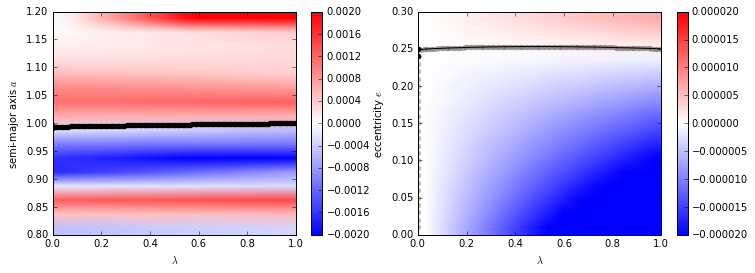

In [194]:
fig = plt.figure(figsize=(12,4))
ax = plt.subplot(121)
extent = [min(gridlam),max(gridlam),min(grida),max(grida)]
ax.set_xlim(extent[0],extent[1])
ax.set_ylabel("semi-major axis $a$")
ax.set_ylim(extent[2],extent[3])
ax.set_xlabel("$\lambda$")
ax.plot(track[-1],track[0],color="black")
ax.scatter(track[-1],track[0],color="black")
im = ax.imshow(grid, vmin=-0.002, vmax=0.002, cmap="bwr", origin="lower",aspect='auto', extent=extent) #interpolation="none",
cb = plt.colorbar(im, ax=ax)

ax = plt.subplot(122)
extent = [min(gridlam),max(gridlam),min(gride),max(gride)]
ax.set_xlim(extent[0],extent[1])
ax.set_ylabel("eccentricity $e$")
ax.set_ylim(extent[2],extent[3])
ax.set_xlabel("$\lambda$")
ax.plot(track[-1],track[1],color="black")
ax.scatter(track[-1],track[1],color="black",alpha=0.2)
im = ax.imshow(grid2, vmin=-0.00002, vmax=0.00002, cmap="bwr", origin="lower",aspect='auto', extent=extent) #interpolation="none",
cb = plt.colorbar(im, ax=ax)

In [158]:
def null(A, eps=1e-10):
    u, s, vh = np.linalg.svd(A)
    padding = max(0,np.shape(A)[1]-np.shape(s)[0])
    null_mask = np.concatenate(((s <= eps), np.ones((padding,),dtype=bool)),axis=0)
    null_space = scipy.compress(null_mask, vh, axis=0)
    return scipy.transpose(null_space)

In [193]:
def rhs(y):
    a, e, lam = y
    x = (a,e)
    _H, _H_dx, _H_dl = H_d(x,lam)
    M = np.array([[_H_dx[0,0], _H_dx[0,1], _H_dl[0]],
                  [_H_dx[1,0], _H_dx[1,1], _H_dl[1]]]                  )
    nv = null(M)[:,0]
    return nv

maxiterations = 200
track = np.zeros((3,maxiterations))
y = np.array([simple_a, 0.,0.])
ds = 0.01
i=0
while y[-1] < 1. and i<maxiterations:
    dy = rhs(y)
    #ym = np.copy(y) + 0.5*ds*np.copy(dy)
    #dy = rhs(ym)
    y += ds*dy
    track[:,i] = y
    i+=1
track = track[:,0:i]